# Analyzing the simulation result

In [13]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
# from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpdikj
# from tqdm import trange
from time import sleep

%matplotlib inline

Settings and functions

In [ ]:
matplotlib.rcParams.update({
    'figure.dpi': 300,
    'figure.titlesize': 15,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.title_fontsize': 13
})

In [ ]:
def read_output_veh(data):
    temp = df['vehOnRoad']
    veh_on_road = sum(temp[int((len(temp)+1)/2):])/24
    other_info = df.iloc[-1] - df.iloc[int((len(temp)-1)/2)]
    charge_times = other_info.loc['chargingTrip'].tolist()/24
    
    taxi_data = other_info.loc[['generatedTaxiPass','taxiServedPass','taxiLeavedPass']].tolist()
    bus_data = other_info.loc[['generatedBusPass','busServedPass','busLeavedPass']].tolist()

    taxi_data = np.array(taxi_data)/24
    bus_data = np.array(bus_data)/24
    
    return veh_on_road,charge_times,taxi_data,bus_data

In [ ]:
def plot_radar(values, feature, color, marker, style, label, ax):
    N = len(values)
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/(2*N)
    values=np.concatenate((values,[values[0]]))
    angles2=np.concatenate((angles,[angles[0]]))
    ax.plot(angles2, values, marker = marker, linestyle = style, linewidth=1, markersize=5, label = label, color = color)
    ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.set_ylim(0,1)

## To tune

In [2]:
a = [1,2,3,4]

In [3]:
def plot_radar_n(values,true_values,feature, colors, markers, styles, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/(2*N)*0.5
    angles2=np.concatenate((angles,[angles[0]]))
    
    noised_values = values+1e-3*np.random.random(values.shape)
    
    for num in range(nums):
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], markers[num], styles[num], labels[num], ax)
        n = 0
        for i in range(len(angles)):
            baseline_value = true_values[n, 0]
            a, b = angles2[i], plot_value[i]
            text_n = true_value[n]
            c = noised_values[i, :]
            rank = sorted(c).index(c[num])
            # print(a,rank)
            if text_n<1000:
                ax.text(a, rank*0.1+0.2, '%.1f' % text_n, ha='center', va='center', fontsize=8, color=colors[num])
            else:
                if(text_n == baseline_value):
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.1+0.2, r'{:.1f}%({:.0f})'.format(text_n, baseline_value), ha='center', va='center', fontsize=8, color=colors[num])
                else:
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.1+0.2, r'{:.1f}%'.format(text_n), ha='center', va='center', fontsize=8, color=colors[num])
            n+=1
    
    plt.legend(bbox_to_anchor=(1.05, 0.30))
    ax.grid(True)

In [4]:
from sklearn.preprocessing import MinMaxScaler

def fun(data):
    scaler = (data-np.min(data,axis = 0))/ ((np.max(data,axis = 0)+1e-4)-np.min(data,axis = 0)) * 0.4 + 0.5
    return scaler

# Parameter tuning

 'Occupancy rate', "Occupied mileage",
               'Idling mileage', 'Taxi served passengers', 'Bus served passengers', 
               'Taxi left passengers', 'Bus left passengers',
               'Taxi waiting time (min)', 'Bus waiting time (min)',
               'Taxi energy consumption (kwh)', 'Bus energy consumption (kwh)',
              'Taxi charging duration (h)','Taxi charging times',\
               'Taxi waiting in charging queue (min)',\
               'Bus charging duration (h)','Bus charging times',\
              'Bus waiting in charging queue (min)'

# Pattern finding

In [5]:
def process_data2(curr_folder, ev_num, start_hour = 3, end_hour = 27):
    # Consider the vehicle trip "departured" between the start_hour and the end_hour
    filenames = os.listdir(curr_folder)
    for file in filenames:
        if "ZoneLog" in file:
            df_zone = pd.read_csv(curr_folder+file)
            # df_zone = pd.read_csv(curr_folder+file)
        elif "NetworkLog" in file:
            df_network = pd.read_csv(curr_folder+file)
        elif "EVLog" in file:
            df_ev = pd.read_csv(curr_folder+file)
        elif "BusLog" in file:
            df_bus = pd.read_csv(curr_folder+file)
        elif "LinkLog" in file:
            pass
            # df_link  = pd.read_csv(curr_folder+file)
        elif "ChargerLog" in file:
            df_charger = pd.read_csv(curr_folder+file)
            
            
    last_time = 12000 * end_hour
    first_time = 12000 * start_hour
    df_ev = df_ev[df_ev['distance']>0]
    df_bus = df_bus[df_bus['routeID']!=-1]
    
    occu_rate=(np.mean(df_ev[(df_ev['tripType']==1) & (df_ev['departureTime']<=last_time) & (df_ev['departureTime']>=first_time)]['passNum']))
    
    # note: this is picked up, not served
    taxi_served_pass = (df_network[(df_network['tick']==last_time)]['taxiPickupPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['taxiPickupPass'].values[0] )
    bus_served_pass = (df_network[(df_network['tick']==last_time)]['busPickupPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['busPickupPass'].values[0] )
    combined_served_pass = (df_network[(df_network['tick']==last_time)]['combinePickupPart1'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['combinePickupPart1'].values[0] )
    
    taxi_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedTaxiPass'].values[0] -
                        df_network[(df_network['tick']==first_time)]['generatedTaxiPass'].values[0] )
    bus_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedBusPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['generatedBusPass'].values[0] )
    combined_generated_pass = (df_network[(df_network['tick']==last_time)]['generatedCombinedPass'].values[0]  - 
                       df_network[(df_network['tick']==first_time)]['generatedCombinedPass'].values[0] )
    
    # note, unused as this might use passengers generated outside 3-27 hrs
    taxi_left_pass=(df_network[(df_network['tick']==last_time)]['taxiLeavedPass'].values[0]  + \
                     df_network[(df_network['tick']==first_time)]['taxiLeavedPass'].values[0] )
    bus_left_pass=(df_network[(df_network['tick']==last_time)]['busLeavedPass'].values[0]  + \
                    df_network[(df_network['tick']==first_time)]['busLeavedPass'].values[0] )
    
    taxi_wait_time = (np.sum(df_zone[(df_zone['tick']==last_time)]['taxiServedPassWaitingTime'])-np.sum(df_zone[(df_zone['tick']==first_time)]['taxiServedPassWaitingTime']))/(taxi_served_pass+combined_served_pass)/12000
    if(bus_generated_pass>0):
        bus_wait_time = (np.sum(df_zone[(df_zone['tick']==last_time)]['busServedPassWaitingTime'])-np.sum(df_zone[(df_zone['tick']==first_time)]['busServedPassWaitingTime']))/(bus_served_pass+combined_served_pass)/12000
    else:
        bus_wait_time = 0
        

    # Note we use departure time
    taxi_ener_cons = np.sum(np.sum(df_ev[(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['cost']))
    bus_ener_cons = np.sum(np.sum(df_bus[(df_bus['departureTime']<=last_time)&(df_bus['departureTime']>=first_time)]['cost']))
    
    total_mileage = np.sum(np.sum(df_ev[(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    occu_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==1)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    pickup_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==6)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    charging_mileage = np.sum(np.sum(df_ev[(df_ev['tripType']==4)&(df_ev['departureTime']<=last_time)&(df_ev['departureTime']>=first_time)]['distance'])/1609.1)
    
    df_charger['tick'] = df_charger['tick'] -  df_charger['waitingTime']-  df_charger['chargingTime']
    
    taxi_charging_load=np.sum(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==1)]['chargingTime'])/12000.0
    taxi_charging_time= len(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==1)])
    
    bus_charging_load=np.sum(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==2)]['chargingTime'])/12000.0
    bus_charging_time= len(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==2)])
    
    taxi_charging_waiting=(np.mean(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==1)]['waitingTime'])/12000.0*60)
    bus_charging_waiting=(np.mean(df_charger[(df_charger['tick']<=last_time)&(df_charger['tick']>=first_time)&(df_charger['vehType']==2)]['waitingTime'])/12000.0*60)
    
    return occu_rate, total_mileage, occu_mileage, pickup_mileage,charging_mileage,\
           taxi_generated_pass, bus_generated_pass, combined_generated_pass, taxi_served_pass, bus_served_pass, combined_served_pass,\
           taxi_left_pass, bus_left_pass, taxi_wait_time, bus_wait_time, taxi_ener_cons, bus_ener_cons,\
           taxi_charging_load, taxi_charging_time, taxi_charging_waiting, bus_charging_load, bus_charging_time, bus_charging_waiting, taxi_generated_pass+bus_generated_pass+2*combined_served_pass

For the first round of review.

In [213]:
res = np.zeros((2,5,24))

for eco in range(1):
    for bus in range(1):
        for co in range(1):
            for share in range(2):
                for k in range(5):
                    filename = 'scenario_'+str(2) + '_case_' + str([1,3,5,7,9][k%5] + (10 if k>=15 else 0))+'_seed_42_'+\
                    'eco_' + ['false','true'][eco] + \
                    '_bus_' + ['false','true'][bus] + \
                    '_share_'+ ['false','true'][share] + '_demand_100_taxi_3000_bus_40_' + ['pass','co_pass'][co]   +'_100_4'
                    res[share, k, :] = process_data2('exp4/' + filename + '/agg_output/3000_40/', 3000)

C:\Users\ALei\AppData\Local\Temp\ipykernel_13680\1011765953.py:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_zone = pd.read_csv(curr_folder+file)


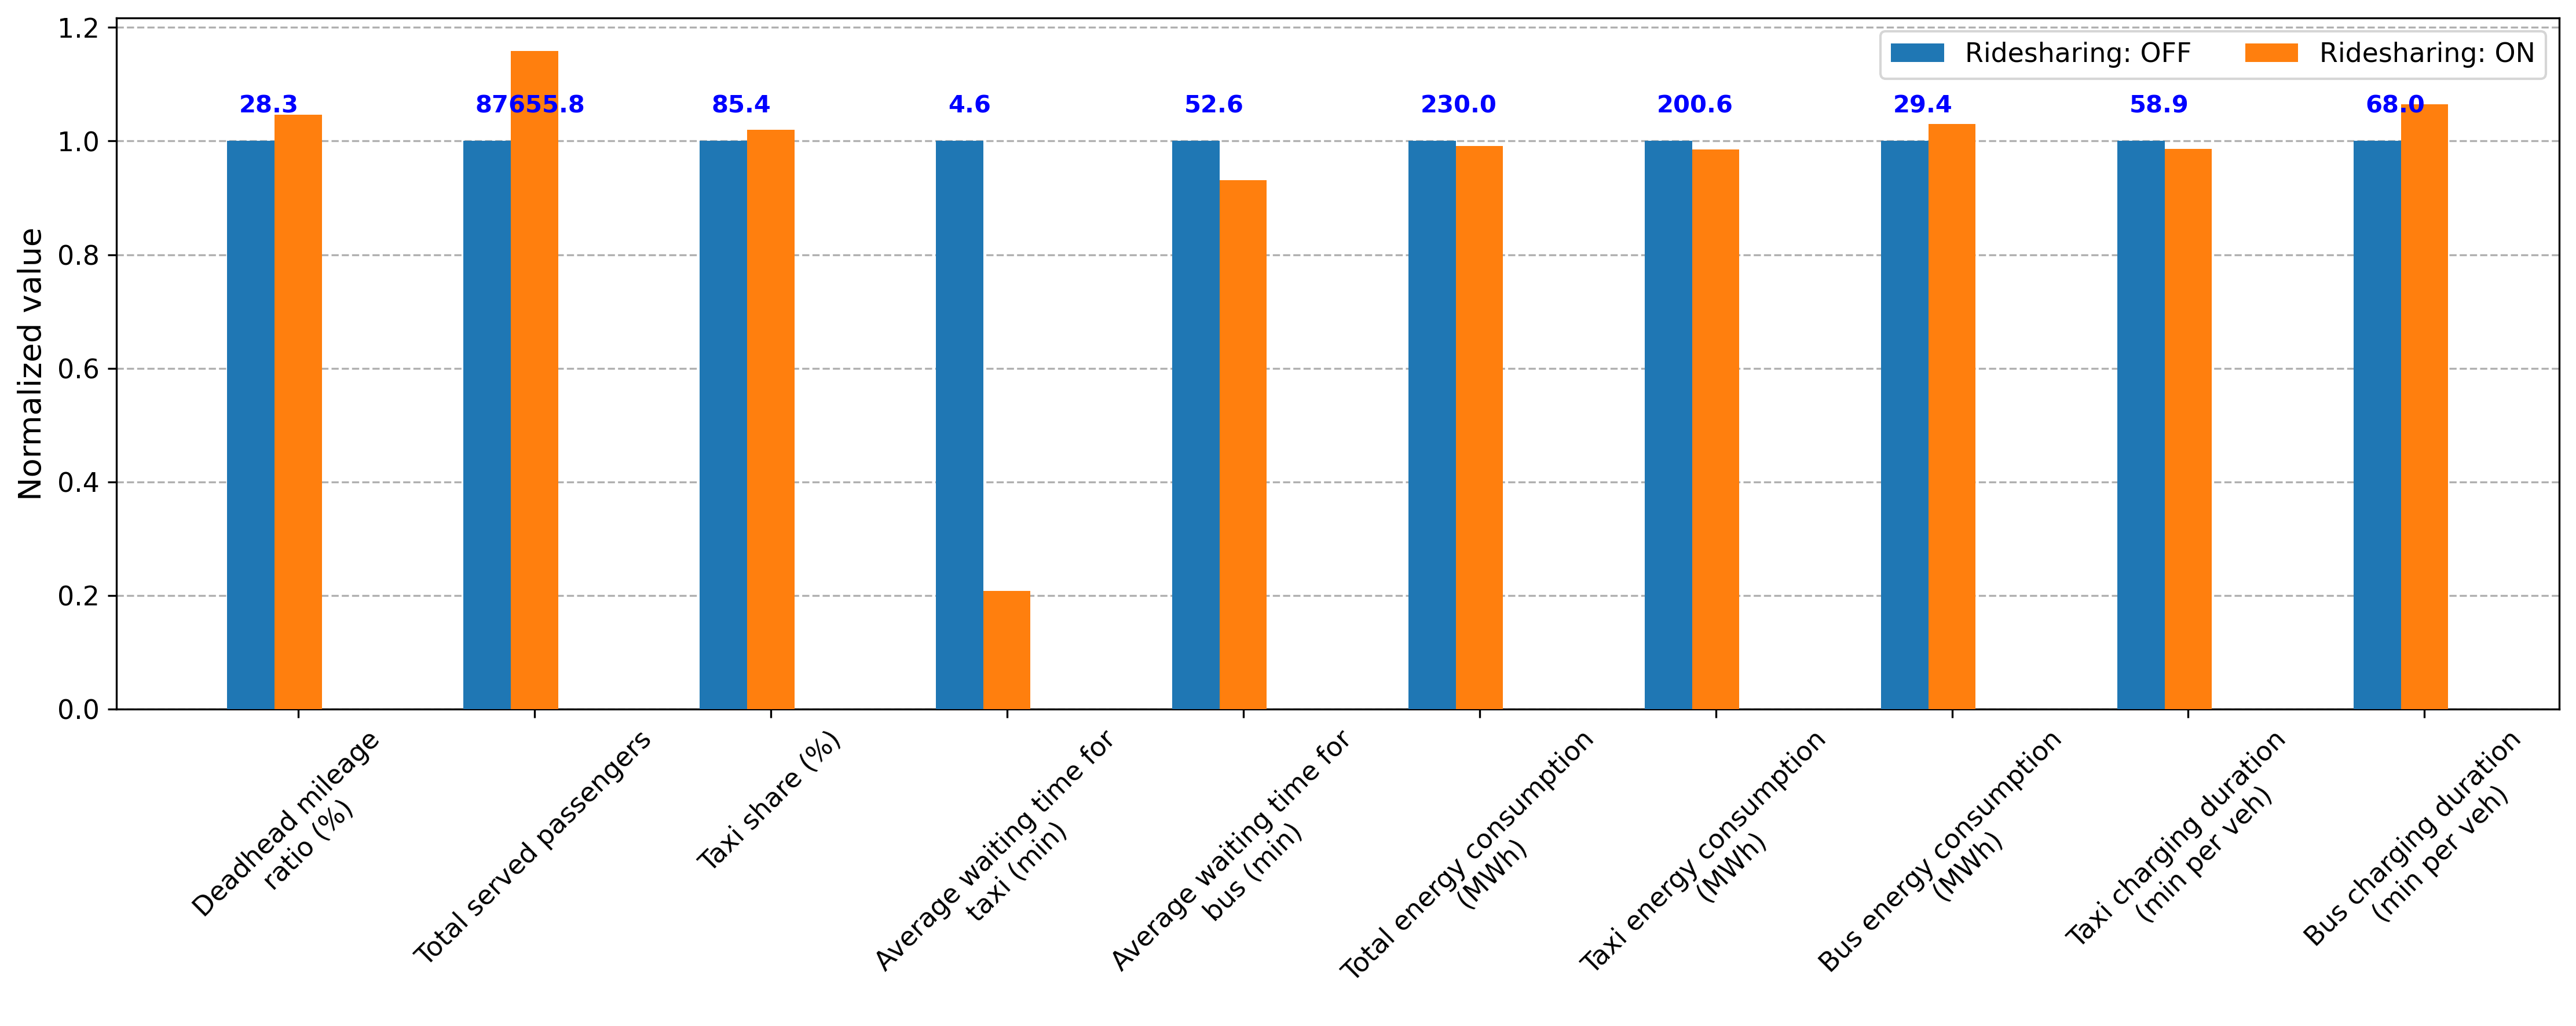

In [279]:
labels = []
original_data = []
error_data = []
for share in range(2):
    labels.append( "Ridesharing:" + ['off', 'on'][share])
    original_data.append([
        (1-np.mean(res[share, :, 2]/res[share, :, 1]))*100,
            #np.mean(res[eco, bus, co, :, 0]),
        (np.mean(res[share, :, 8])),
        100*(np.mean(res[share, :, 8]))/(np.mean(res[share, :, 8]+np.mean(res[share, :, 9]))),
        # np.mean((res[eco, bus, co, :, 8]+res[eco, bus, co, :, 10]/2)/(res[eco, bus, co, :, 8]+res[eco, bus, co, :, 9]+res[eco, bus, co, :, 10])),
        np.mean(res[share, :, 13]*60),
        np.mean(res[share, :, 14]*60),
        np.mean((res[share, :, 15])+np.mean(res[share, :, 16]))/1000,
        np.mean(res[share, :, 15])/1000,
        np.mean(res[share, :, 16])/1000,
        np.mean(res[share, :, 17])/3000*60,
        np.mean(res[share, :, 20])/40*60]
        #np.mean(res[eco, bus,co, :, 19]*60),
        )
    
    # error_data.append([
    #     np.std(res[share, :, 2]/res[share, :, 1])*100,
    #         #np.mean(res[eco, bus, co, :, 0]),
    #     (np.std(res[share, :, 8])),
    #     (np.std(res[share, :, 9])),
    #     # np.mean((res[eco, bus, co, :, 8]+res[eco, bus, co, :, 10]/2)/(res[eco, bus, co, :, 8]+res[eco, bus, co, :, 9]+res[eco, bus, co, :, 10])),
    #     np.std(res[share, :, 13]*60),
    #     np.std(res[share, :, 14]*60)]
    #     #np.mean(res[eco, bus,co, :, 19]*60),
    #     )

original_data = np.array(original_data)
# error_data = np.array(error_data)
all_data = fun(np.stack(original_data)).T

fig,ax = plt.subplots(figsize=(15,6))
# ax = fig.add_subplot(111, polar=True)
# ax.set_facecolor('#EEE') 
# ax.grid(color="grey", linewidth=1, linestyle="-") 
#ax.grid(False)    
# ax_old.axis('Off')
# ax.spines['polar'].set_visible(False)  

feature_veh = ['Deadhead mileage\nratio (%)',
               'Total served passengers', 
               'Taxi share (%)', 
               'Average waiting time for\ntaxi (min)', 
               'Average waiting time for\nbus (min)',
               'Total energy consumption\n (MWh)',
               'Taxi energy consumption\n  (MWh)', 
               'Bus energy consumption\n  (MWh)', 
               'Taxi charging duration\n  (min per veh)',
               'Bus charging duration\n  (min per veh)'
               ]

colors =sns.color_palette("Spectral", len(labels)+3)
colors = colors[0:4] + colors[7:11]
styles = ['-','-','--','--','-','-','--','--']
marks = ['o','s','o','s','o','s','o','s','o','s']
plt.grid( axis = 'y', zorder = 0, linestyle='dashed')

plt.bar(np.arange(10)-0.2, original_data[0]/original_data[0],  label ='Ridesharing: OFF', width = 0.2, zorder = 3)
plt.bar(np.arange(10), original_data[1]/original_data[0], label ='Ridesharing: ON', width = 0.2, zorder = 3)

for i, v in enumerate(original_data[0]):
    ax.text(i - .25, 1 + 0.05,  str(round(v,1)), color='blue', fontweight='bold')

plt.ylabel("Normalized value")
plt.xticks(np.arange(10), feature_veh, rotation=45)
# plot_radar_n(all_data,original_data.T,feature_veh,colors, marks, styles, labels, ax)
# ax.set_yticklabels([])
plt.legend(ncol=2)
plt.tight_layout()



plt.savefig('fig/exp3/ridesharing1_.pdf')
plt.savefig('fig/exp3/ridesharing1_.png', dpi = 300)

In [ ]:
res = np.zeros((2,2,2,20,24))

for eco in range(2):
    for bus in range(2):
        for co in range(2):
            for k in range(20):
                filename = 'scenario_'+str(k//5) + '_case_' + str([1,3,5,7,9][k%5] + (10 if k>=15 else 0))+'_seed_42_'+\
                'eco_' + ['false','true'][eco] + \
                '_bus_' + ['false','true'][bus] + \
                '_share_true_demand_100_taxi_3000_bus_40_' + ['pass','co_pass'][co]  
                res[eco, bus, co, k, :] = process_data2('exp3/' + filename + '/agg_output/3000_40/', 3000)

## Figure 1 

In [8]:
def plot_radar(values, feature, color, marker, style, label, ax):
    N = len(values)
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/(2*N)
    values=np.concatenate((values,[values[0]]))
    angles2=np.concatenate((angles,[angles[0]]))
    ax.plot(angles2, values, marker = marker, linestyle = style, linewidth=3, markersize=17, label = label, color = color)
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize = 24, weight='bold')
    ax.set_ylim(0,1)

In [9]:
def plot_radar_n(values,true_values,feature, colors, markers, styles, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/(2*N)*0.5
    angles2=np.concatenate((angles,[angles[0]]))
    
    noised_values = values+1e-3*np.random.random(values.shape)
    
    for num in range(nums):
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], markers[num], styles[num], labels[num], ax)
        n = 0
        for i in range(len(angles)):
            baseline_value = true_values[n, 0]
            a, b = angles2[i], plot_value[i]
            text_n = true_value[n]
            c = noised_values[i, :]
            rank = sorted(c).index(c[num])
            # print(a,rank)
            if text_n<1000:
                ax.text(a, rank*0.11+0.2, '%.1f' % text_n, ha='center', va='center', fontsize=17, color=colors[num])
            else:
                if(text_n == baseline_value):
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.11+0.2, r'{:.1f}%({:.0f})'.format(text_n, baseline_value), ha='center', va='center',  fontsize=17,  color=colors[num])
                else:
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.11+0.2, r'{:.1f}%'.format(text_n), ha='center', va='center',  fontsize=17, color=colors[num])
            n+=1
    
    # ax.legend(bbox_to_anchor=(1.05, 0.30), prop={'size': 16})
    ax.grid(True)

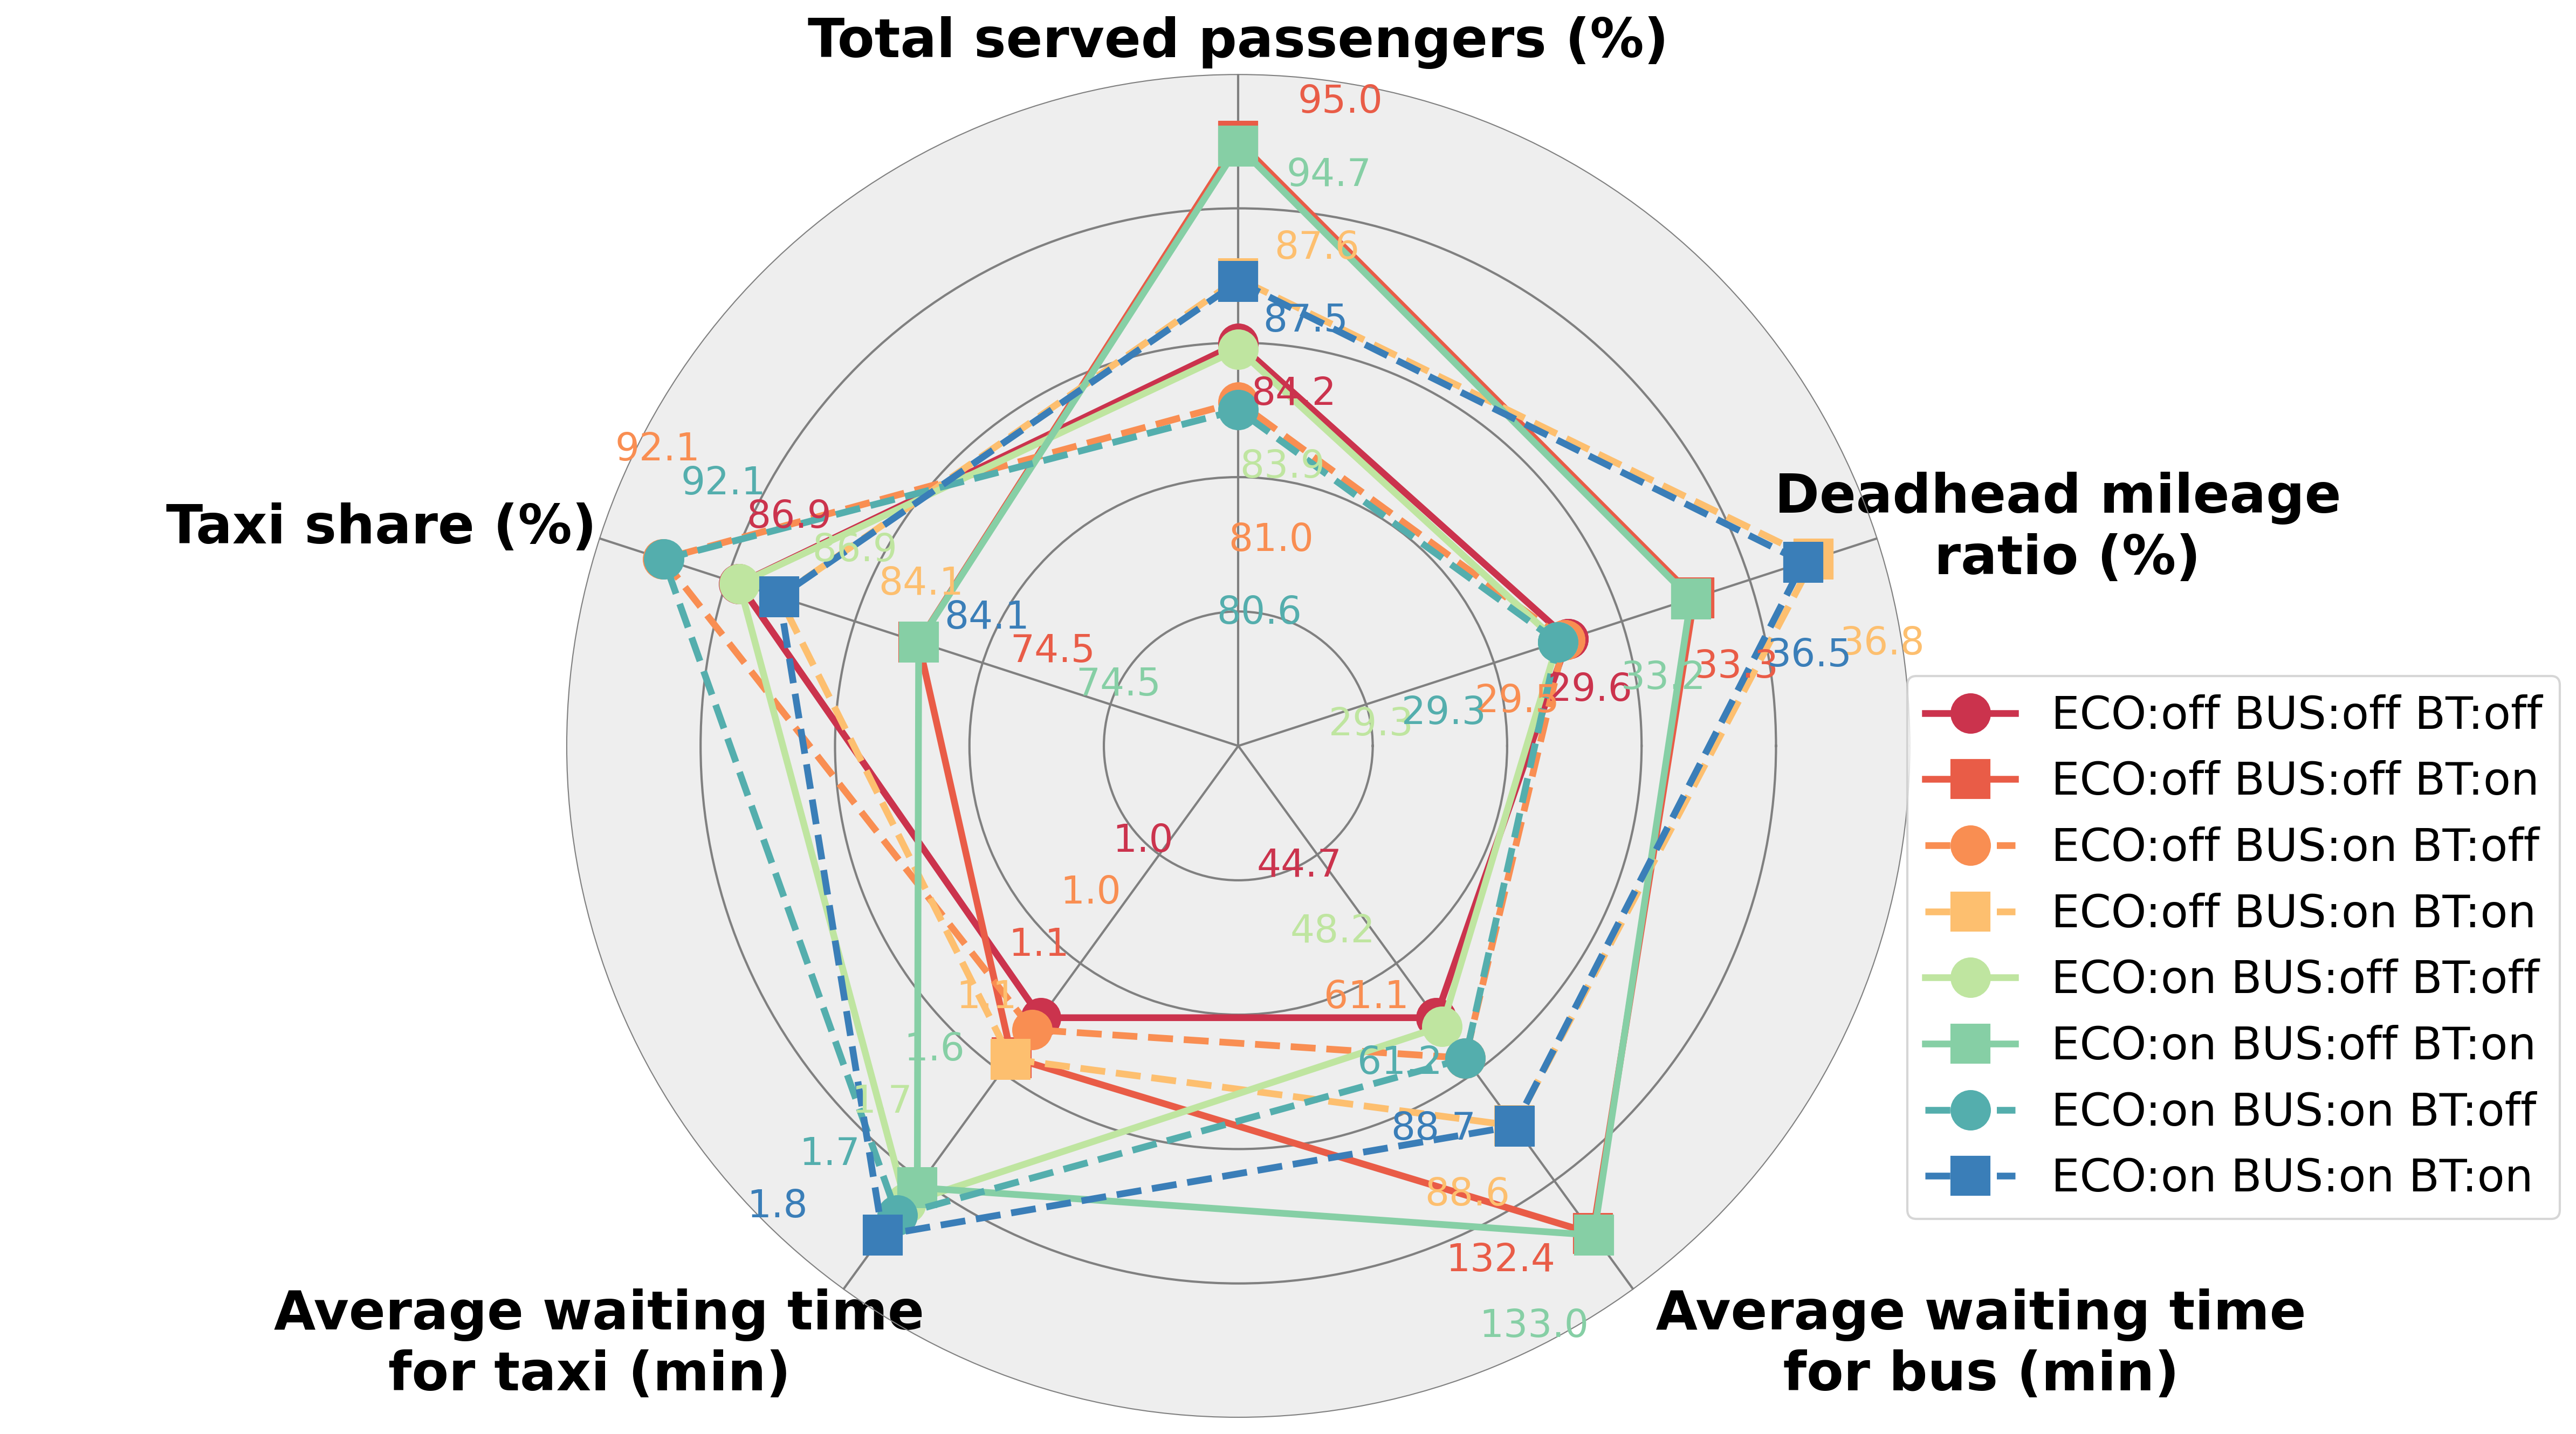

In [362]:
original_data = []
labels = []
for eco in range(2):
    for bus in range(2):
        for co in range(2):
            labels.append( "ECO:"+['off','on'][eco]+" BUS:"+['off','on'][bus] + " BT:" + ['off', 'on'][co])
            original_data.append([
            (1-np.mean(res[eco, bus, co, :, 2]/res[eco, bus, co, :, 1]))*100,
            #np.mean(res[eco, bus, co, :, 0]),
            (np.mean(res[eco, bus, co, :, 8]+res[eco, bus, co, :, 10])),
            (np.mean(res[eco, bus, co, :, 9]+res[eco, bus, co, :, 10])),
            # np.mean((res[eco, bus, co, :, 8]+res[eco, bus, co, :, 10]/2)/(res[eco, bus, co, :, 8]+res[eco, bus, co, :, 9]+res[eco, bus, co, :, 10])),
            np.mean(res[eco, bus, co, :, 13]*60),
            np.mean(res[eco, bus, co, :, 14]*60)]
             )

original_data = np.array(original_data)
all_data = fun(np.stack(original_data)).T

fig,ax_old = plt.subplots(figsize=(16,9))
ax = fig.add_subplot(111, polar=True)
ax.set_facecolor('#EEE') 
ax.grid(color="grey", linewidth=1, linestyle="-") 
#ax.grid(False)    
ax_old.axis('Off')
ax.spines['polar'].set_visible(False)  

feature_veh = ['                Deadhead mileage\n                 ratio (%)',
               'Total served passengers (%)', 
               'Taxi share (%)                    ', 
               '\nAverage waiting time                        \nfor taxi (min)                         ', 
               '\n                                   Average waiting time\n                                   for bus (min)'
               ]

colors =sns.color_palette("Spectral", len(labels)+3)
colors = colors[0:4] + colors[7:11]
styles = ['-','-','--','--','-','-','--','--']
marks = ['o','s','o','s','o','s','o','s','o','s']

plot_radar_n(all_data,original_data.T,feature_veh,colors, marks, styles, labels, ax)
ax.set_yticklabels([])
plt.legend(bbox_to_anchor=(1.5,0.35), loc="center right", fontsize="20")
plt.tight_layout()

plt.savefig('fig/exp3/radar_served_.pdf')
plt.savefig('fig/exp3/radar_served_.png', dpi = 300)

In [20]:
def plot_radar_n(values,true_values,feature, colors, markers, styles, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/(2*N)*0.5
    angles2=np.concatenate((angles,[angles[0]]))
    
    noised_values = values+1e-3*np.random.random(values.shape)
    
    for num in range(nums):
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], markers[num], styles[num], labels[num], ax)
        n = 0
        for i in range(len(angles)):
            baseline_value = true_values[n, 0]
            a, b = angles2[i], plot_value[i]
            text_n = true_value[n]
            c = noised_values[i, :]
            rank = sorted(c).index(c[num])
            # print(a,rank)
            if text_n<1000:
                ax.text(a, rank*0.091+0.25, '%.1f' % text_n, ha='center', va='center', fontsize=17, color=colors[num])
            else:
                if(text_n == baseline_value):
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.091+0.25, r'{:.1f}%({:.0f})'.format(text_n, baseline_value), ha='center', va='center',  fontsize=17,  color=colors[num])
                else:
                    text_n = text_n/baseline_value*100
                    ax.text(a, rank*0.091+0.25, r'{:.z1f}%'.format(text_n), ha='center', va='center',  fontsize=17, color=colors[num])
            n+=1
    
    # ax.legend(bbox_to_anchor=(1.05, 0.30), prop={'size': 16})
    ax.grid(True)

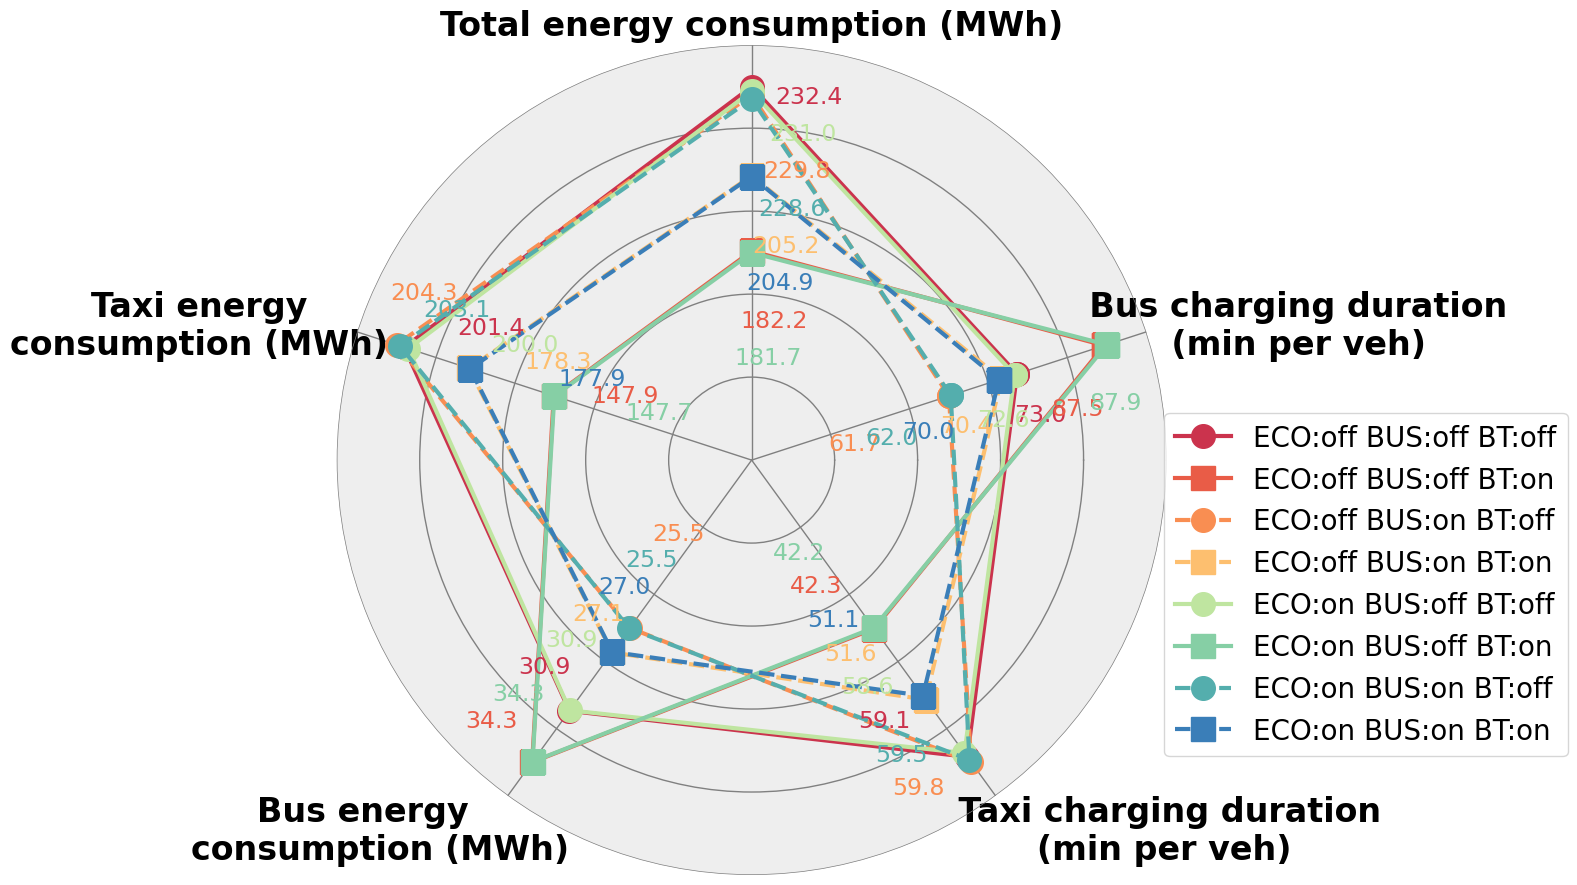

In [24]:
original_data = []
labels = []
for eco in range(2):
    for bus in range(2):
        for co in range(2):
            # m,n,p = 0,0,0
            labels.append( "ECO:"+['off','on'][eco]+" BUS:"+['off','on'][bus] + " BT:" + ['off', 'on'][co])
            original_data.append([
            res2[eco, bus, co, 0, 4],    
            res2[eco, bus, co, 0, 0]/100*res_baseline[0]/1000,
            res2[eco, bus, co, 0, 1]/100*res_baseline[1]/1000,
            res2[eco, bus, co, 0, 2]/100*res_baseline[2]/1000,
            res2[eco, bus, co, 0, 3]
            ]
             )
original_data = np.array(original_data)
all_data = fun(np.stack(original_data)).T

fig,ax_old = plt.subplots(figsize=(16, 9))
ax = fig.add_subplot(111, polar=True)
ax.set_facecolor('#EEE') 
ax.grid(color="grey", linewidth=1, linestyle="-") 
#ax.grid(False)    
ax_old.axis('Off')
ax.spines['polar'].set_visible(False)  

feature_veh = ['                       Bus charging duration\n                       (min per veh)',
               'Total energy consumption (MWh)',
               'Taxi energy                        \nconsumption (MWh)                        ', 
               ' \nBus energy                       \nconsumption (MWh)                    ', 
               '\n                            Taxi charging duration\n                           (min per veh)'
               ]

# title = 'Taxi results'
# file_name = 'taxi'
colors =sns.color_palette("Spectral", len(labels)+3)
colors = colors[0:4] + colors[7:11]
styles = ['-','-','--','--','-','-','--','--']
marks = ['o','s','o','s','o','s','o','s','o','s']

plot_radar_n(all_data,original_data.T,feature_veh,colors, marks, styles, labels, ax)

ax.set_yticklabels([])

plt.legend(bbox_to_anchor=(1.5,0.35), loc="center right", fontsize="20")

plt.tight_layout()

# plt.show()
plt.savefig('fig/exp3/radar_energy_.pdf')
plt.savefig('fig/exp3/radar_energy_.png', dpi = 300)


# Energy patterns

In [23]:
import powerlaw
from scipy.stats import kstest
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import geopandas as gpd

In [ ]:
for eco in range(2):
    for bus in range(2):
        for co in range(2):
            fig, ax = plt.subplots(figsize=(4,3))
            for k in range(20):
                filename = 'scenario_'+str(k//5) + '_case_' + str([1,3,5,7,9][k%5] + (10 if k>=15 else 0))+'_seed_42_'+\
                            'eco_' + ['false','true'][eco] + \
                            '_bus_' + ['false','true'][bus] + \
                            '_share_true_demand_100_taxi_3000_bus_40_' + ['pass','co_pass'][co] 
                curr_folder = 'exp3/' + filename + '/agg_output/3000_40/'
                filenames = os.listdir(curr_folder)
                for file in filenames:
                    if "ZoneLog" in file:
                        pass
                        # df_zone = pd.read_csv(curr_folder+file)
                    elif "NetworkLog" in file:
                        pass
                        # df_network = pd.read_csv(curr_folder+file)
                    elif "EVLog" in file:
                        pass
                        # df_ev = pd.read_csv(curr_folder+file)
                    elif "BusLog" in file:
                        pass
                        # df_bus = pd.read_csv(curr_folder+file)
                    elif "LinkLog" in file:
                        df_link  = pd.read_csv(curr_folder+file)
                nyc_road = gpd.read_file("map/road_fileNYC.shp")
                df_link_agg = df_link[df_link['tick']==27*12000].reset_index()
                df_link_agg2 = df_link[df_link['tick']==3*12000].reset_index()
                df_link_agg = pd.merge(left=df_link_agg, right=df_link_agg2, on = 'linkID')
                df_link_agg.fillna(0, inplace=True)
                df_link_agg['consumption_x'] -= df_link_agg['consumption_y']
                df_link_agg = pd.merge(left = df_link_agg, right = nyc_road, on = 'linkID')
                # df_link_agg['consumption_z'] = df_link_agg['consumption_x']  
                df_link_agg.sort_values(by = ['consumption_x'], inplace=True, ascending=False)
                # df_link_agg = df_link_agg[df_link_agg['length']>50]
                # df_link_agg['consumption_x'] = df_link_agg['consumption_x']/(df_link_agg['length']/1609) 
                # try different settings
#                 fit = powerlaw.Fit(df_link_agg['consumption_z'].values[df_link_agg['consumption_z'].values>0]/24,
#                                   xmin = min(df_link_agg['consumption_z'].values[df_link_agg['consumption_z'].values>0]/24),
#                                   xmax = max(df_link_agg['consumption_z'].values[df_link_agg['consumption_z'].values>0]/24))

                # fit.lognormal.plot_pdf(color= 'blue',linestyle='--',label='Fitted')
                # fit.plot_cdf(color= 'red', label='Simulated', original_data=False)
                #sort data
                y = 100*np.cumsum(df_link_agg['consumption_x'].values)/np.sum(df_link_agg['consumption_x'].values)
                #calculate CDF values
                x = 100. * np.arange(len(y)) / (len(y) - 1)
                plt.plot(x, y, alpha=0.7)
            plt.ylabel("Cumulative energy\nconsumption (%)")
            plt.xlabel("Number of links (%)")
            ax.set_xscale('log')
                # ax.set_yscale('log')

                # Create a Rectangle patch
#                 rect = Rectangle((0.1, 0), 0.9, 105, linewidth=1, edgecolor='none', facecolor='C3', alpha=0.2)

#                 # Add the patch to the Axes
#                 ax.add_patch(rect)

#                 # Create a Rectangle patch
#                 rect2 = Rectangle((1, 0), 9, 105, linewidth=1, edgecolor='none', facecolor='C1', alpha=0.2)

#                 # Add the patch to the Axes
#                 ax.add_patch(rect2)

#                 # Create a Rectangle patch7yujkn
#                 rect3 = Rectangle((10, 0), 90, 105, linewidth=1, edgecolor='none', facecolor='C2', alpha=0.2)

#                 # Add the patch to the Axes
#                 ax.add_patch(rect3)

                # add KS test
                # KS, pvalue = kstest(df_link_agg['consumption_z'].values[df_link_agg['consumption_z'].values>0]/24, fit.lognormal.cdf)
                # plt.text(x = 1e-2, y = 1e-3, \
                #          s = '$\mu: '+str(round(fit.lognormal.mu,3))+'$ $\sigma: ' + str(round(fit.lognormal.sigma,3))+ '$\n'\
                #         +'KS statistic:'+str(round(KS,3)))#+'\np-value:'+str(round(pvalue,3)))#'$y \propto x^{-'+str(round(fit.power_law.alpha,3))+'}$')

                # add a patch at 50\% of energy consumption
                # threshold = 0.8 * np.sum(df_link_agg['consumption_z'].values[df_link_agg['consumption_z'].values>0])
                # percentage = 1-len(np.where(np.cumsum(sorted_list)> threshold)[0])/len(df_link_agg['consumption_z'].values)
                # target_x = sorted_list[index]
                # boxes = [Rectangle((target_x, 0), max(df_link_agg['consumption_x'].values) - target_x, 10)]
                # pc = PatchCollection(boxes, facec"olor = 'grey', alpha = 0.5)
                # print(round(percentage*100,1))

                # plt.text(x = target_x+300, y = 1e-4, \
                              # s = str(round(percentage*100,1)) + '% links costs 80% energy',\
                        # rotation=90, va='center')

                # ax.add_collection(pc)
                # plt.ylim([1e-8, 10])
            plt.xlim([0.1,100])
            plt.ylim([0,105])
            plt.grid()

            plt.tight_layout()
            plt.savefig('fig/exp3/link_'+str(eco)+'_'+str(bus)+'_'+str(co)+'.pdf')
            plt.savefig('fig/exp3/link_'+str(eco)+'_'+str(bus)+'_'+str(co)+'.png', dpi = 300)
            
